## Train ResNets

### created by Yuying Liu, 04/30/2020

This script is a template for training neural network time-steppers for different systems and different time scales. To reproduce the results in the paper, one needs to obtain all 11 neural network models for each nonlinear system under study. For setup details, please refer to Table 2 in the paper.

In [9]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [14]:
# adjustables

k = 5                       # model index: should be in {0, 2, ..., 10}
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'VanDerPol'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [2, 128, 128, 128, 2]  # architecture of the neural network

# paths
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
n_forward = 5
step_size = 2**k

noise_levels = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2]

In [15]:
# load models
models = list()
for noise in noise_levels:
    try:
        model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
        print(model_name)
        models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
    except:
        print("not found")
        break

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
  

model_D32_noise0.0.pt
model_D32_noise0.01.pt
model_D32_noise0.02.pt
model_D32_noise0.05.pt
model_D32_noise0.1.pt
model_D32_noise0.2.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


(array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
        1.e+01, 1.e+02]), <a list of 10 Text yticklabel objects>)

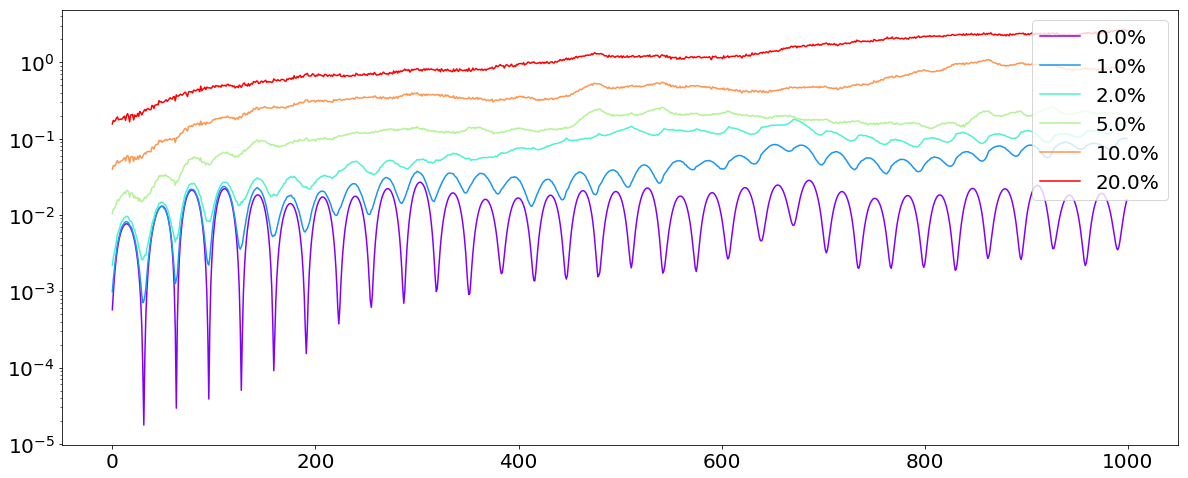

In [16]:
#graph for d1

mse_list_big = list()
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(models))))
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).detach().numpy()
    
#     plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))


n_steps = 1000
for i in range(len(models)):
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise_levels[i])))
    rgb = next(colors)
    y_preds = models[i].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     plt.plot(y_preds[0,:,0].cpu().detach().numpy())
#     plt.plot(y_preds[0,:,1].cpu().detach().numpy())

#     plt.plot(test_data[0,1:n_steps,0])#.cpu().detach().numpy())
#     plt.plot(test_data[0,1:n_steps,1])#.cpu().detach().numpy())
# # plt.show()

# print((y_preds_2 - test_data[:,1:,:]).shape)

# print(((y_preds_2 - test_data[:,1:,:])**2).shape)

    mse = torch.mean((y_preds - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
    mse_list_big.append(mse)

    plt.semilogy(mse, label = str(noise_levels[i]*100) + "%", color=rgb)

plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


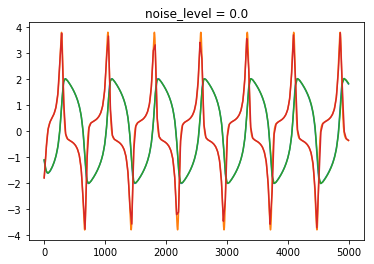

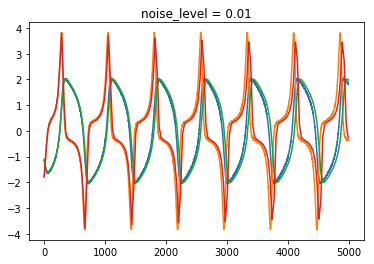

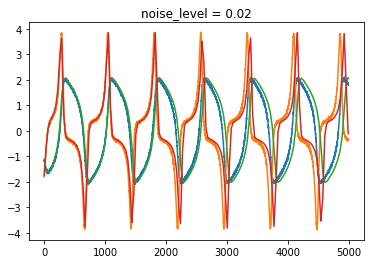

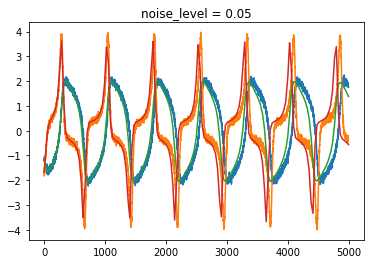

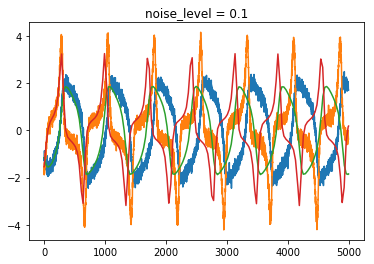

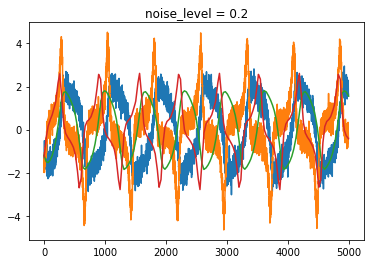

In [17]:

n_steps = 5000
idx_snapshot = 2
for i in range(len(models)):
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise_levels[i])))
    y_preds = models[i].uni_scale_forecast(torch.tensor(test_data[idx_snapshot:idx_snapshot+1, 0, :]).float(), n_steps=n_steps)
    plt.plot(test_data[idx_snapshot,1:n_steps,0])#.cpu().detach().numpy())
    plt.plot(test_data[idx_snapshot,1:n_steps,1])#.cpu().detach().numpy())
    
    plt.plot(y_preds[0,:,0].cpu().detach().numpy())
    plt.plot(y_preds[0,:,1].cpu().detach().numpy())
    
    plt.title("noise_level = "+ str(noise_levels[i]))

    
    plt.show()


model_D4_noise0.0.pt
model_D4_noise0.01.pt
model_D4_noise0.02.pt
model_D4_noise0.05.pt
model_D4_noise0.1.pt
model_D4_noise0.2.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

(array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
        1.e+00, 1.e+01, 1.e+02]), <a list of 11 Text yticklabel objects>)

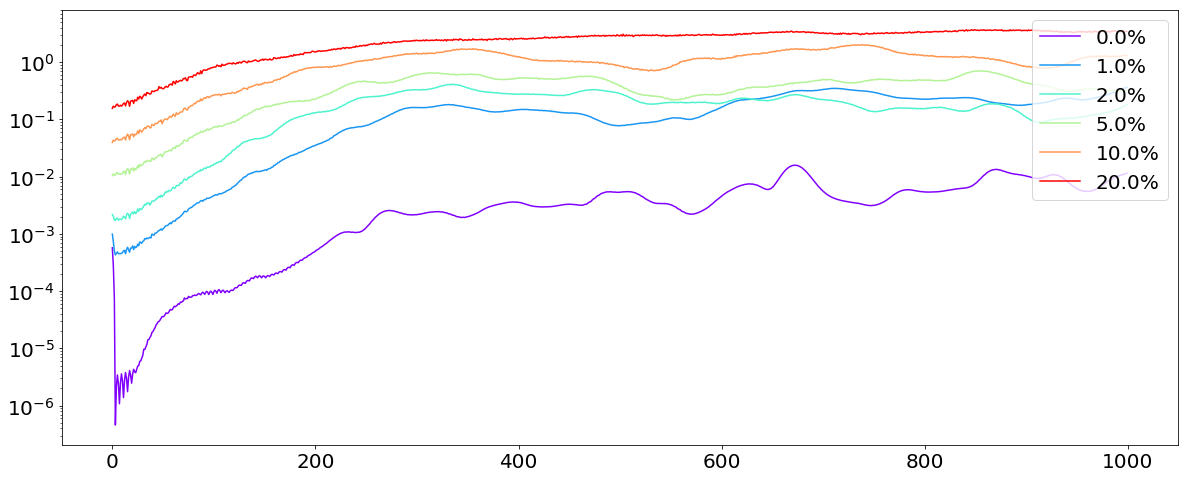

In [18]:
# adjustables

k = 2                       # model index: should be in {0, 2, ..., 10}
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'VanDerPol'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epoch = 100000            # the maximum training epoch 
batch_size = 320              # training batch size
arch = [2, 128, 128, 128, 2]  # architecture of the neural network

# paths
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
n_forward = 5
step_size = 2**k

noise_levels = [0.0, 0.01, 0.02, 0.05, 0.1, 0.2]

# load models
models = list()
for noise in noise_levels:
    try:
        model_name = 'model_D{}_noise{}.pt'.format(step_size, noise)
        print(model_name)
        models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
    except:
        print("not found")
        break

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
  

#graph for d1

mse_list_small = list()
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(models))))
# for k in range(len(preds_mse)):
#     err = preds_mse[k]
#     mean = err.mean(0).detach().numpy()
    
#     plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))


n_steps = 1000
for i in range(len(models)):
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise_levels[i])))
    rgb = next(colors)
    y_preds = models[i].uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
#     plt.plot(y_preds[0,:,0].cpu().detach().numpy())
#     plt.plot(y_preds[0,:,1].cpu().detach().numpy())

#     plt.plot(test_data[0,1:n_steps,0])#.cpu().detach().numpy())
#     plt.plot(test_data[0,1:n_steps,1])#.cpu().detach().numpy())
# # plt.show()

# print((y_preds_2 - test_data[:,1:,:]).shape)

# print(((y_preds_2 - test_data[:,1:,:])**2).shape)

    mse = torch.mean((y_preds - test_data[:,1:n_steps+1,:])**2, axis = (0,2))
    mse_list_small.append(mse)

    plt.semilogy(mse, label = str(noise_levels[i]*100) + "%", color=rgb)

plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
        1.e+00, 1.e+01, 1.e+02]), <a list of 11 Text yticklabel objects>)

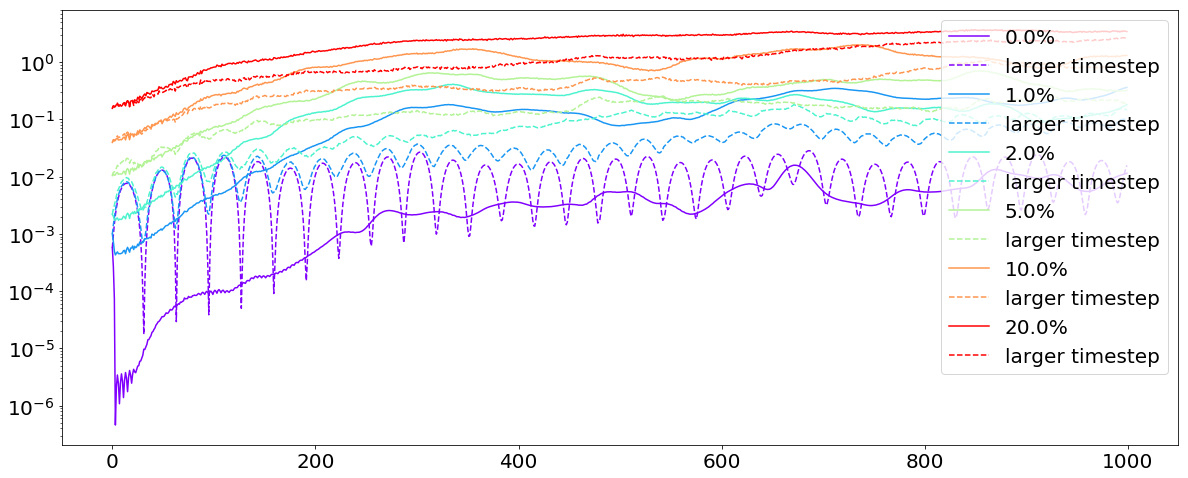

In [19]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(models))))
for i in range(len(models)):
    rgb = next(colors)

    
    mse =  mse_list_small[i]

    plt.semilogy(mse, label = str(noise_levels[i]*100) + "%", color=rgb)
    
#     rgb = next(colors)
    mse =  mse_list_big[i]

    plt.semilogy(mse, '--', label = 'larger timestep', color=rgb)

plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

/usr/local/lib/python3.6/dist-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


0.0
0.00022118370947532188
0.000884734837901287
0.0055295927368830475
0.022118370947532183
0.08847348379012873


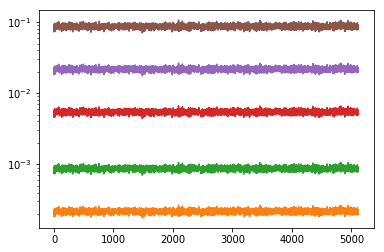

In [29]:

n_steps = 1000
idx_snapshot = 2
test_no_noise =     test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise_levels[0])))
for i in range(len(models)):
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise_levels[i])))
    mse = np.mean((test_data - test_no_noise)**2, axis = (0,2))
    
    plt.semilogy(mse)
    print(mse[0])
#     plt.show()


/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


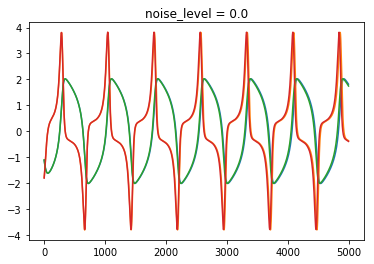

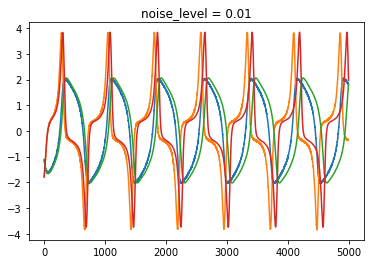

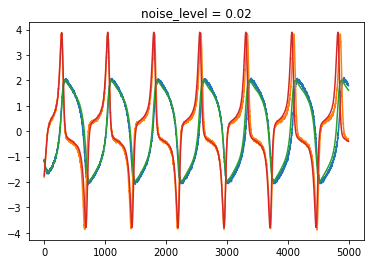

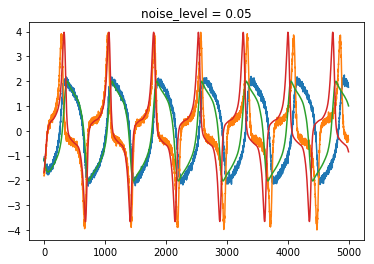

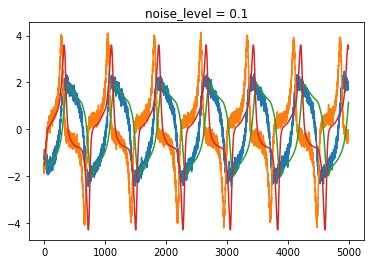

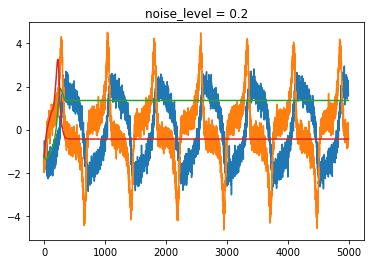

In [21]:

n_steps = 5000
idx_snapshot = 2
for i in range(len(models)):
    test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise_levels[i])))
    y_preds = models[i].uni_scale_forecast(torch.tensor(test_data[idx_snapshot:idx_snapshot+1, 0, :]).float(), n_steps=n_steps)
    plt.plot(test_data[idx_snapshot,1:n_steps,0])#.cpu().detach().numpy())
    plt.plot(test_data[idx_snapshot,1:n_steps,1])#.cpu().detach().numpy())
    
    plt.plot(y_preds[0,:,0].cpu().detach().numpy())
    plt.plot(y_preds[0,:,1].cpu().detach().numpy())
    
    plt.title("noise_level = "+ str(noise_levels[i]))

    
    plt.show()
